<a href="https://colab.research.google.com/github/SyedHarshath/Computer-Vision/blob/main/Canny_Edge_Detection%2CLoG_and_DoG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

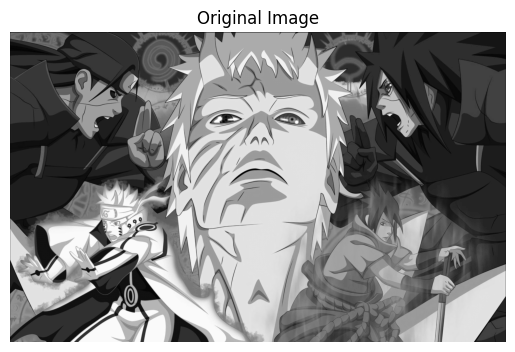

In [ ]:
image = cv2.imread("narutoshippuden.jpg")
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.title("Original Image")
plt.imshow(image_gray,cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
blurred_image = cv2.GaussianBlur(image_gray, (5, 5), 1.4)

### SOBEL EDGE DETECTION (3X3)

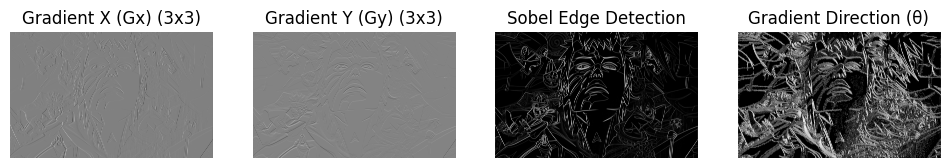

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

sobel_edges = cv2.magnitude(sobel_x, sobel_y)
sobel_edges = cv2.convertScaleAbs(sobel_edges)

gradient_direction = np.arctan2(sobel_y, sobel_x) * (180 / np.pi)
gradient_direction = (gradient_direction + 180) % 180

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sobel_x, cmap='gray')
plt.title("Gradient X (Gx) (3x3)")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(sobel_y, cmap='gray')
plt.title("Gradient Y (Gy) (3x3)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(sobel_edges, cmap='gray')
plt.title("Sobel Edge Detection")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(gradient_direction, cmap='gray')
plt.title("Gradient Direction (θ)")
plt.axis("off")

plt.show()

### CANNY EDGE DETECTION

In [ ]:
def non_maximum_suppression(gradient_magnitude,gradient_direction):
    rows,cols = gradient_magnitude.shape
    suppressed = np.zeros((rows,cols),dtype=np.uint8)

    for i in range(1,rows-1):
        for j in range(1,cols-1):
            angle = gradient_direction[i,j]
            q,r = 255,255

            if 0 <= angle < 22.5 or 157.5 <= angle <= 180:
                q = gradient_magnitude[i,j+1]
                r = gradient_magnitude[i,j-1]
            elif 22.5 <= angle < 67.5 :
                q = gradient_magnitude[i-1,j+1]
                r = gradient_magnitude[i+1,j-1]
            elif 67.5 <= angle < 112.5 :
                q = gradient_magnitude[i-1,j]
                r = gradient_magnitude[i+1,j]
            elif 112.5 <= angle < 157.5 :
                q = gradient_magnitude[i-1,j-1]
                r = gradient_magnitude[i+1,j+1]

            if gradient_magnitude[i,j] >= q and gradient_magnitude[i,j] >= r:
                suppressed[i,j] = gradient_magnitude[i,j]
            else :
                suppressed[i,j] = 0
    return suppressed

In [ ]:
nms_image = non_maximum_suppression(sobel_edges, gradient_direction)
nms_image = (nms_image / nms_image.max()) * 255
nms_image = nms_image.astype(np.uint8)

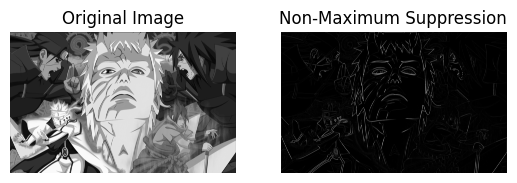

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image_gray,cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(nms_image,cmap='gray')
plt.title("Non-Maximum Suppression")
plt.axis("off")

plt.show()

In [ ]:
def double_thresholding(image,low_threshold,high_threshold):
    strong = 255
    weak = 50

    strong_i,strong_j = np.where(image >= high_threshold)
    weak_i,weak_j = np.where((image <= high_threshold) & (image >= low_threshold))

    thresholded = np.zeros_like(image,dtype=np.uint8)
    thresholded[strong_i,strong_j] = strong
    thresholded[weak_i,weak_j] = weak

    return thresholded,weak,strong

In [ ]:
threshold,weak,strong = double_thresholding(nms_image,50,50)

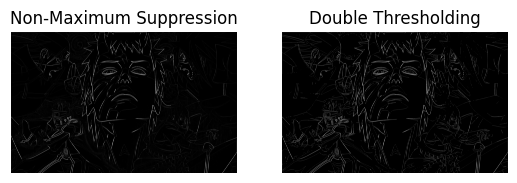

In [ ]:
plt.subplot(1,2,1)
plt.imshow(nms_image,cmap='gray')
plt.title("Non-Maximum Suppression")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(threshold,cmap='gray')
plt.title("Double Thresholding")
plt.axis("off")

plt.show()

In [ ]:
def hysteresis(image,weak,strong):
    m,n = image.shape
    for i in range(1,m-1):
        for j in range(1,n-1):
            if image[i,j]==weak:
                if (image[i+1, j-1] == strong or image[i+1, j] == strong or image[i+1, j+1] == strong
                        or image[i, j-1] == strong or image[i, j+1] == strong
                        or image[i-1, j-1] == strong or image[i-1, j] == strong or image[i-1, j+1] == strong):
                    image[i, j] = strong
                else:
                    image[i,j] = 0
    return image

In [ ]:
canny_edge = hysteresis(threshold,weak,strong)

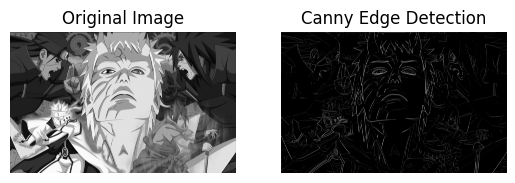

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image_gray,cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(canny_edge,cmap='gray')
plt.title("Canny Edge Detection")
plt.axis("off")

plt.show()

### LoG and DoG

In [ ]:
def gaussian_kernel(size, sigma):
    half_size = size // 2
    kernel = np.zeros((size, size), dtype=np.float32)

    for i in range(size):
        for j in range(size):
            x, y = i - half_size, j - half_size
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    return kernel / kernel.sum()

In [ ]:
def manual_convolution(image, kernel):
    img_height, img_width = image.shape
    k_size = kernel.shape[0]
    pad = k_size // 2
    padded_image = np.pad(image, pad, mode='constant', constant_values=0)
    convolved = np.zeros_like(image)
    for i in range(img_height):
        for j in range(img_width):
            sum_value = 0
            for m in range(k_size):
                for n in range(k_size):
                    sum_value += padded_image[i+m, j+n] * kernel[m, n]
            convolved[i, j] = sum_value
    return convolved

In [ ]:
def laplacian_of_gaussian(image, size=5, sigma=1.0):
    gaussian = gaussian_kernel(size, sigma)
    blurred_image = manual_convolution(image, gaussian)
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    log_result = manual_convolution(blurred_image, laplacian_kernel)
    return gaussian, blurred_image, log_result

In [ ]:
def difference_of_gaussian(image, size=5, sigma1=1.0, sigma2=2.0):
    gaussian1 = gaussian_kernel(size, sigma1)
    gaussian2 = gaussian_kernel(size, sigma2)
    blurred1 = manual_convolution(image, gaussian1)
    blurred2 = manual_convolution(image, gaussian2)
    dog_result = blurred1 - blurred2
    return gaussian1, gaussian2, blurred1, blurred2, dog_result


In [ ]:
gaussian, blurred_image, log_result = laplacian_of_gaussian(image_gray)
gaussian1, gaussian2, blurred1, blurred2, dog_result = difference_of_gaussian(image_gray)

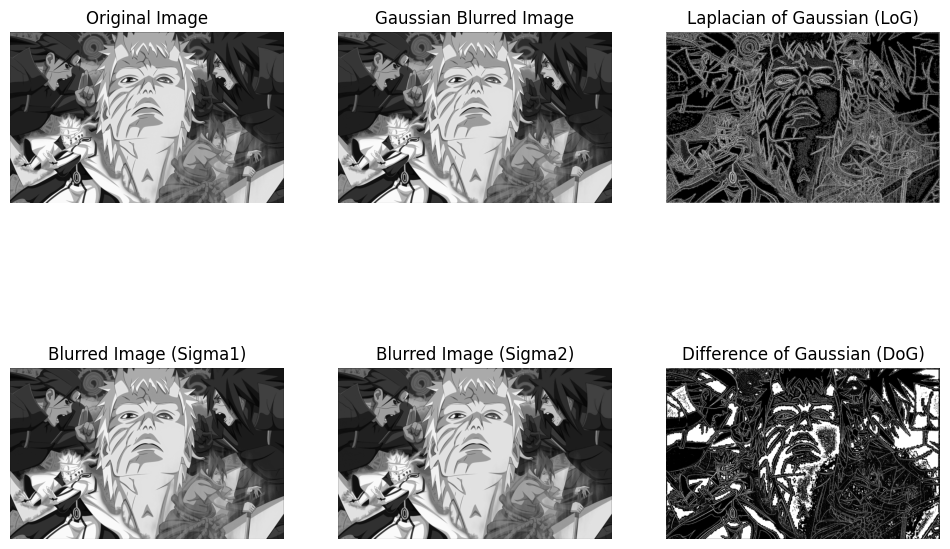

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(image_gray, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title("Gaussian Blurred Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(log_result, cmap='gray')
plt.title("Laplacian of Gaussian (LoG)")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(blurred1, cmap='gray')
plt.title("Blurred Image (Sigma1)")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(blurred2, cmap='gray')
plt.title("Blurred Image (Sigma2)")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(dog_result, cmap='gray')
plt.title("Difference of Gaussian (DoG)")
plt.axis('off')

plt.show()